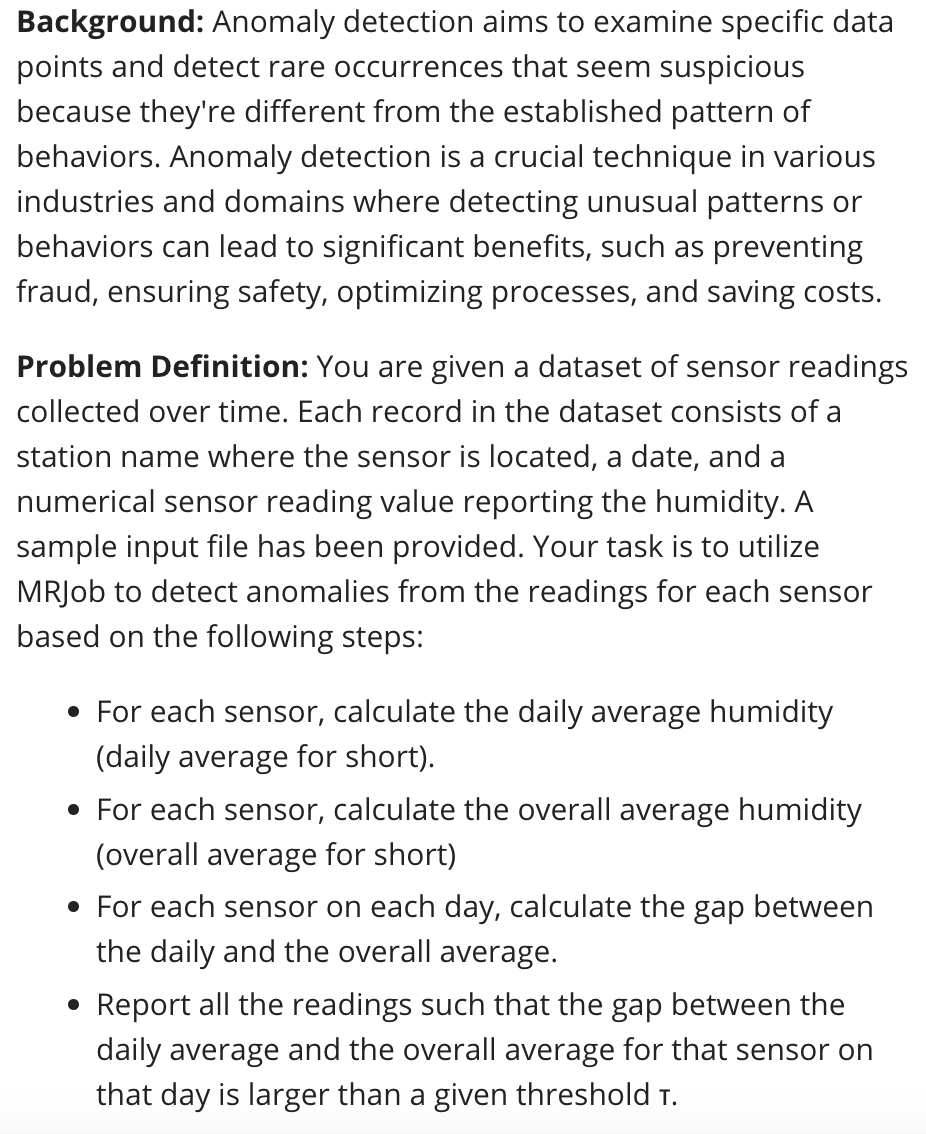

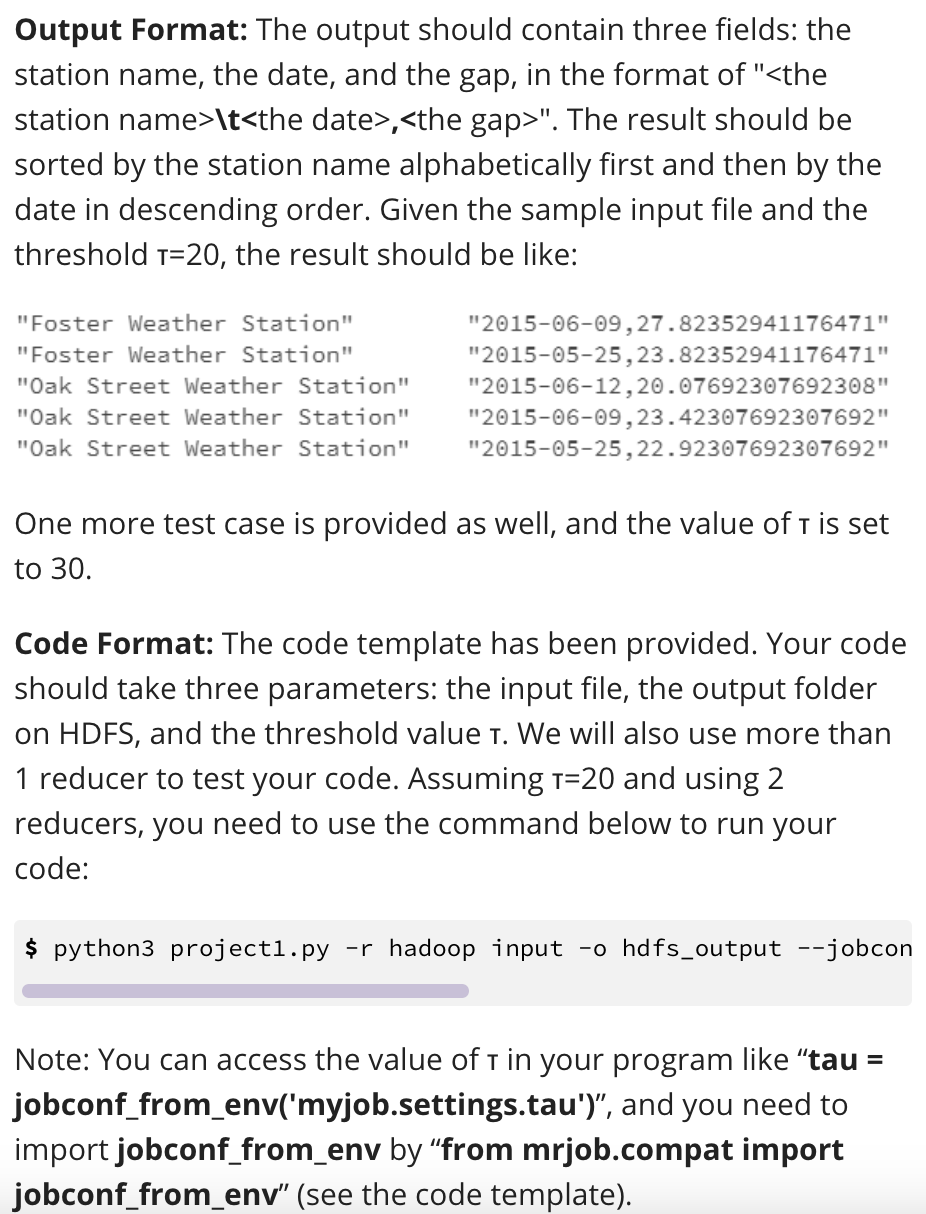

In [2]:
# Use this command to test: 
# python3 project1.py -r hadoop input -o hdfs_output --jobconf myjob.settings.tau=20 --jobconf mapreduce.job.reduces=2

# Delete existed output dir: hdfs dfs -rm -r hdfs_output

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):   

    def mapper(self, _, line):
        address, date, humidity = line.strip().split(',')
        humidity = humidity.strip()
        yield (station, date), float(humidity)
    
    def reducer(self, key, values):
        station, date = key
        daily_total = 0
        daily_count = 0

        # Calculate daily average humidity
        for value in values:
            daily_total += value
            daily_count += 1
        daily_average = daily_total / daily_count

        # Calculate overall average humidity
        overall_total = 0
        overall_count = 0
        for _, daily_humidity in self.reducer_values:
            overall_total += daily_humidity
            overall_count += 1
        overall_average = overall_total / overall_count

        gap = abs(overall_average - daily_average)

        if gap > self.options.threshold:
            yield station, (date, gap)
        
    
    SORT_VALUES = True

    JOBCONF = {
      'map.output.key.field.separator': ',',
      'mapreduce.partition.keypartitioner.options':'-k1,1',
      'mapreduce.job.output.key.comparator.class':'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
      'mapreduce.partition.keycomparator.options':'-k1,1'
    }
    
if __name__ == '__main__':
    proj1.run()

IndentationError: expected an indented block (565105241.py, line 8)

In [9]:
for line in open('sample.txt'):
    # strip the line
    val = line.strip()
    # split the line with the symbol ','
    words = line.split(',')
    # delete the /n in the last word
    words[2] = words[2].strip()
    print(words)

['Foster Weather Station', '2015-06-09', '45.0']
['Oak Street Weather Station', '2015-06-03', '67.0']
['Foster Weather Station', '2015-05-25', '49.0']
['Oak Street Weather Station', '2015-05-28', '56.0']
['Oak Street Weather Station', '2015-06-14', '79.0']
['Oak Street Weather Station', '2015-06-12', '95.0']
['Foster Weather Station', '2015-06-07', '77.0']
['Oak Street Weather Station', '2015-06-09', '65.0']
['Oak Street Weather Station', '2015-06-06', '90.0']
['Foster Weather Station', '2015-06-01', '79.0']
['Oak Street Weather Station', '2015-05-31', '82.0']
['Oak Street Weather Station', '2015-05-31', '89.0']
['Foster Weather Station', '2015-06-15', '85.0']
['Foster Weather Station', '2015-05-27', '76.0']
['Foster Weather Station', '2015-06-04', '61.0']
['Oak Street Weather Station', '2015-06-13', '98.0']
['Foster Weather Station', '2015-06-11', '84.0']
['Oak Street Weather Station', '2015-06-13', '86.0']
['Oak Street Weather Station', '2015-06-09', '38.0']
['Foster Weather Station'

In [ ]:
for line in open('test.txt'):
    word, freq = line.strip().split('\t',1)
    dictionary[word] = dictionary.get(word, 0) + int(freq)

In [34]:
for line in open('sample.txt'):
    station, date_humidity = line.split(",",1)
    nodes = date_humidity.strip().split(" ")
    
    for node in nodes:
        print("*," + node + "," + station, "" )

*,2015-06-09,45.0,Foster Weather Station 
*,2015-06-03,67.0,Oak Street Weather Station 
*,2015-05-25,49.0,Foster Weather Station 
*,2015-05-28,56.0,Oak Street Weather Station 
*,2015-06-14,79.0,Oak Street Weather Station 
*,2015-06-12,95.0,Oak Street Weather Station 
*,2015-06-07,77.0,Foster Weather Station 
*,2015-06-09,65.0,Oak Street Weather Station 
*,2015-06-06,90.0,Oak Street Weather Station 
*,2015-06-01,79.0,Foster Weather Station 
*,2015-05-31,82.0,Oak Street Weather Station 
*,2015-05-31,89.0,Oak Street Weather Station 
*,2015-06-15,85.0,Foster Weather Station 
*,2015-05-27,76.0,Foster Weather Station 
*,2015-06-04,61.0,Foster Weather Station 
*,2015-06-13,98.0,Oak Street Weather Station 
*,2015-06-11,84.0,Foster Weather Station 
*,2015-06-13,86.0,Oak Street Weather Station 
*,2015-06-09,38.0,Oak Street Weather Station 
*,2015-06-10,76.0,Foster Weather Station 
*,2015-06-11,88.0,Foster Weather Station 
*,2015-06-03,82.0,Foster Weather Station 
*,2015-05-25,52.0,Oak Street Wea

In [3]:
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol

class proj1(MRJob):

    def mapper(self, _, line):
        station, date, humidity = line.strip().split(',')
        humidity = humidity.strip()
        yield (station, date), float(humidity)

    def reducer_init(self):
        self.daily_totals = {}
        self.daily_counts = {}
        self.overall_total = 0
        self.overall_count = 0

    def reducer(self, key, values):
        station, date = key
        daily_total = 0
        daily_count = 0

        for humidity in values:
            daily_total += humidity
            daily_count += 1
            self.overall_total += humidity
            self.overall_count += 1

        daily_average = daily_total / daily_count
        overall_average = self.overall_total / self.overall_count
        gap = abs(daily_average - overall_average)

        yield None, (station, date, gap)

    def reducer_final(self):
        pass

    def steps(self):
        return [
            self.mr(mapper=self.mapper, reducer_init=self.reducer_init, reducer=self.reducer, reducer_final=self.reducer_final)
        ]

    def reducer_output(self, _, value):
        threshold = self.options.threshold
        for station, date, gap in value:
            if gap > threshold:
                yield None, f"{station}\t{date},{gap}"

if __name__ == '__main__':
    proj1.run()


'Oak Street Weather Station'

In [ ]:
import math
import sys
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class ImportantTerms(MRJob):
                
    def mapper(self, _, line):
        date, texts = line.split(",")
        if len(texts) == 0:
            return
        words = texts.split(" ")
        year = date[0:4]
        output = {}

        for word in words:
            output[word] = output.get(word, 0) + 1
        
        for word, count in output.items():
            yield f'{word}#9999', year
            yield f'{word}#{year}', count

    def combiner(self, key, values):
        word, year = key.split("#")        
        if year == "9999":
            years = set()
            for y in values:
                years.add(y)
            for y in years:
                yield f'{word}#9999', y
        else:
            localtf = sum(values)
            yield f'{word}#{year}', localtf
            
    def reducer_init(self):
        self.YF=-1	#record current word in how many years
        self.cur_word = ""
        self.N = int(jobconf_from_env('myjob.settings.years'))
        self.beta = float(jobconf_from_env('myjob.settings.beta'))
        
            
    def reducer(self, key, values):        
        word, year = key.split("#")

        if year == "9999":
            years = set()
            for y in values:
                years.add(y)
            self.YF = len(years)            

            self.cur_word = word
        else:
            tf = sum(values)            
            tfidf = tf * math.log10(self.N/self.YF) 
            
            if tfidf >= self.beta:
                yield self.cur_word, year+","+ str(tfidf) 
   
    SORT_VALUES = True

    JOBCONF = {
      'map.output.key.field.separator': '#',
      'mapreduce.partition.keypartitioner.options':'-k1,1',
      'mapreduce.job.output.key.comparator.class':'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
      'mapreduce.partition.keycomparator.options':'-k1,1 -k2,2nr'
    }
           
if __name__ == '__main__':
    ImportantTerms.run()


## Test 1

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):   
    
    def configure_args(self):
        super(proj1, self).configure_args()
        self.add_passthru_arg('--tau', type=float, help='Threshold value τ')
    
    def mapper(self, _, line):
        address, date, humidity = line.strip().split(',')
        humidity = humidity.strip()
        yield (station, date), float(humidity)
    
    # def reducer(self, key, values):
    #     station, date = key
    #     daily_total = 0
    #     daily_count = 0

    #     # Calculate daily average humidity
    #     for value in values:
    #         daily_total += value
    #         daily_count += 1
    #     daily_average = daily_total / daily_count

    #     # Calculate overall average humidity
    #     overall_total = 0
    #     overall_count = 0
    #     for _, daily_humidity in self.reducer_values:
    #         overall_total += daily_humidity
    #         overall_count += 1
    #     overall_average = overall_total / overall_count

    #     gap = abs(overall_average - daily_average)

    #     if gap > self.options.threshold:
    #         yield f"{station}", f"\t {date},{gap}"
    
    # SORT_VALUES = True

    # JOBCONF = {
    #   'map.output.key.field.separator': ',',
    #   'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
    #   'mapreduce.partition.keypartitioner.options': '-k1,1',
    #   'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r',
    #   'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
    # }
    def reducer_init(self):
        self.daily_averages = {}
        self.overall_averages = {}
        self.tau = self.options.tau

    def reducer(self, key, values):
        station, date = key
        humidity_values = list(values)
        
        # Calculate daily average
        daily_avg = sum(humidity_values) / len(humidity_values)
        self.daily_averages[station] = daily_avg
        
        # Calculate overall average
        overall_avg = sum(humidity_values) / len(humidity_values)
        self.overall_averages[station] = overall_avg

    def reducer_final(self):
        for station in self.daily_averages:
            daily_avg = self.daily_averages[station]
            overall_avg = self.overall_averages[station]
            gap = daily_avg - overall_avg
            if abs(gap) > self.tau:
                yield station, (daily_avg, gap)

    def steps(self):
        return [
            MRStep(mapper=self.mapper, reducer_init=self.reducer_init, reducer=self.reducer, reducer_final=self.reducer_final)
        ]
    SORT_VALUES = True

    JOBCONF = {
      'map.output.key.field.separator': ',',
      'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
      'mapreduce.partition.keypartitioner.options': '-k1,1',
      'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r',
      'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
    }

if __name__ == '__main__':
    proj1.run()

## Test 2

In [1]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):   
        
    def mapper_daily_average(self, _, line):
        station, date, humidity = line.strip().split(',')
        humidity = humidity.strip()
        yield (station,date), float(humidity)
        
    def reducer_daily_average(self, station_date, humidity):
        l = list(humidity)
        yield station_date, sum(l)/len(l)
    
    def mapper_overall_average(self, station_date, humidity_daily_average):
        station, date = station_date
        yield station, (date, humidity_daily_average)
    
    def reducer_overall_average(self, station, date_humidity_daily_average):
        sum_daily_averages = 0
        count = 0
        date_humidity_overall = []
        
        for date, humidity_daily_average in date_humidity_daily_average:
            sum_daily_averages += humidity_daily_average
            count += 1
            date_humidity_overall.append((date, humidity_daily_average))

        overall_average = sum_daily_averages / count
        for date, humidity_daily_average in date_humidity_overall:
            yield station, (date, humidity_daily_average, overall_average)
    
    def mapper_calculate_gap(self, station, date_humidity_averages):
        date, humidity_daily_average, overall_average = date_humidity_averages
        yield (station,date), (humidity_daily_average,overall_average)
    
    def reducer_calculate_gap_init(self):
        self.tau = int(jobconf_from_env('myjob.settings.tau'))
    
    def reducer_calculate_gap(self, station_date, humidity_averages):
        station, date = station_date
        for humidity_daily_average, overall_average in humidity_averages:
            gap = abs(humidity_daily_average - overall_average)
            if gap > self.tau:
                yield f"{station}", f"{date},{gap}"


    SORT_VALUES = True

    def steps(self):
        JOBCONF1 = {
                'stream.num.map.output.key.fields': 2,
                'map.output.key.field.separator': ',',
                'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                'mapreduce.partition.keypartitioner.options': '-k1,1',
                'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r',
                'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
            }
        return [
            MRStep(mapper=self.mapper_daily_average, 
                   reducer=self.reducer_daily_average),
            MRStep(mapper=self.mapper_overall_average, 
                   reducer=self.reducer_overall_average),
            MRStep(jobconf = JOBCONF1, mapper=self.mapper_calculate_gap,
                   reducer_init = self.reducer_calculate_gap_init,
                   reducer=self.reducer_calculate_gap)
        ]
    
if __name__ == '__main__':
    proj1.run()

ModuleNotFoundError: No module named 'mrjob'

In [23]:
import numpy as np
for line in open('sample.txt'):
    station, date, humidity = line.strip().split(',')
    humidity = humidity.strip()
    l = list(float(humidity))
    print(l)

TypeError: 'float' object is not iterable

## Test 3

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):   
        
    def mapper_daily_average(self, _, line):
        station, date, humidity = line.strip().split(',')
        humidity = humidity.strip()
        yield (station,date), float(humidity)
        
    def reducer_daily_average(self, station_date, humidity):
        l = list(humidity)
        yield station_date, sum(l)/len(l)
    
    def mapper_overall_average(self, station_date, humidity_daily_average):
        station, date = station_date
        yield station, (date, humidity_daily_average)
    
    def reducer_overall_average(self, station, date_humidity_daily_average):
        sum_daily_averages = 0
        count = 0
        date_humidity_overall = []
        
        for date, humidity_daily_average in date_humidity_daily_average:
            sum_daily_averages += humidity_daily_average
            count += 1
            date_humidity_overall.append((date, humidity_daily_average))

        overall_average = sum_daily_averages / count
        for date, humidity_daily_average in date_humidity_overall:
            yield station, (date, humidity_daily_average, overall_average)
    
    def mapper_calculate_gap(self, station, date_humidity_averages):
        date, humidity_daily_average, overall_average = date_humidity_averages
        yield (station,date), (humidity_daily_average,overall_average)
    
    def reducer_calculate_gap_init(self):
        self.tau = int(jobconf_from_env('myjob.settings.tau'))
    
    def reducer_calculate_gap(self, station_date, humidity_averages):
        station, date = station_date
        for humidity_daily_average, overall_average in humidity_averages:
            gap = abs(humidity_daily_average - overall_average)
            if gap > self.tau:
                yield f"{station}", f"{date},{gap}"


    SORT_VALUES = True

    def steps(self):
        JOBCONF = {
            'stream.num.map.output.key.fields': 2,
            'map.output.key.field.separator': ',',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r', 
            'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(mapper=self.mapper_daily_average, 
                   reducer=self.reducer_daily_average),
            MRStep(mapper=self.mapper_overall_average, 
                   reducer=self.reducer_overall_average),
            MRStep(jobconf = JOBCONF, mapper=self.mapper_calculate_gap,
                   reducer_init = self.reducer_calculate_gap_init,
                   reducer=self.reducer_calculate_gap)
        ]
    
if __name__ == '__main__':
    proj1.run()

## Test 4 - need to use multiple mappers and combiners

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):

    def mapper(self, _, line):
        
        # Use strip and split function to split the whole row into three parts
        station, date, humidity = line.strip().split(',')
        # Transform the humidity to the float format
        humidity = float(humidity)
        # The key is tuple:(station, date) and the value is tuple:(humidity, count)
        yield (station, date), (humidity, 1)

    def combiner(self, station_date, humidity_count):
        total_daily_humidity = 0
        count = 0
        for h, c in humidity_count:
            total_daily_humidity += h
            count += c
        yield station_date[0], (station_date[1], total_daily_humidity, count)

    def reducer_calculate_gap_init(self):
        # Access the value of threshold 
        self.tau = float(jobconf_from_env('myjob.settings.tau'))
        
    def reducer(self, station, date_humidity_daily_count):
        overall_humidity = 0
        overall_count = 0
        daily_humidity_data = []

        for date, total_daily_humidity, count in date_humidity_daily_count:
            overall_humidity += total_daily_humidity
            overall_count += count
            daily_humidity_data.append((date, total_daily_humidity / count))

        humidity_overall_average = overall_humidity / overall_count

        for date, daily_average in daily_humidity_data:
            gap = abs(daily_average - humidity_overall_average)
            if gap > self.tau:
                yield f"{station}", f"{date},{gap}"

    SORT_VALUES = True
    
    def steps(self):
        
        JOBCONF = {
            'stream.num.map.output.key.fields': 2,
            'map.output.key.field.separator': ',',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r', 
            'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                jobconf = JOBCONF,
                mapper = self.mapper,
                combiner = self.combiner,
                reducer_init = self.reducer_calculate_gap_init,
                reducer=self.reducer
            )
        ]

if __name__ == '__main__':
    proj1.run()


## Test 5 - successfully get the result but order is not right, and there is only one mapper

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):

    def mapper1(self, _, line):
        
        # Use strip and split function to split the whole row into three parts
        station, date, humidity = line.strip().split(',')
        # Transform the humidity to the float format
        humidity = float(humidity)
        # The key is tuple:(station, date) and the value is tuple:(humidity, count)
        yield (station, date), (humidity, 1)

    def reducer1(self, station_date, humidity_count):
        
        total_daily_humidity = 0
        count = 0
        # Iterate through the value to calculate the daily average humidity
        for h, c in humidity_count:
            total_daily_humidity += h
            count += c
        
        humidity_daily_average = total_daily_humidity / count
        
        yield station_date[0], (station_date[1], humidity_daily_average, count)

    def mapper2(self, station, date_humidity_daily_count):

        yield station, date_humidity_daily_count
        
    def reducer_calculate_gap_init(self):
        # Access the value of threshold 
        self.tau = float(jobconf_from_env('myjob.settings.tau'))
        
    def reducer2(self, station, date_humidity_daily_count):
        
        overall_humidity = 0
        overall_count = 0
        daily_humidity_data = []

        # Iterate through the values to calculate the overall average humidity
        for date, humidity_daily_average, count in date_humidity_daily_count:
            overall_humidity += humidity_daily_average * count
            overall_count += count
            daily_humidity_data.append((date, humidity_daily_average))

        humidity_overall_average = overall_humidity / overall_count

        # Iterate through the values to calculate the gap between the daily and the overall average of humidity
        for date, humidity_daily_average in daily_humidity_data:
            gap = abs(humidity_daily_average - humidity_overall_average)
            if gap > self.tau:
                yield f"{station}", f"{date},{gap}"

    SORT_VALUES = True
    
    def steps(self):
        
        JOBCONF = {
            'stream.num.map.output.key.fields': 2,
            'map.output.key.field.separator': ',',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r', 
            'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                mapper=self.mapper1,
                reducer=self.reducer1
            ),
            MRStep(
                jobconf = JOBCONF,
                mapper=self.mapper2,
                reducer_init = self.reducer_calculate_gap_init,
                reducer=self.reducer2
            )
        ]

if __name__ == '__main__':
    proj1.run()


In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):

    def mapper(self, _, line):
        
        station, date_humidity = line.split(",",1)
        a_date_humidity = date_humidity.strip().split(" ")
        # Transform the humidity to the float format
        humidity = float(humidity)
        for new in a_date_humidity:
            yield "a," + station + "," + new, 1

    def combiner(self, key, count):
        a, station, date_humidity = key.split(",")  
        count = sum(count)
        yield station, (date_humidity, count)

    def reducer_calculate_gap_init(self):
        # Access the value of threshold 
        self.tau = float(jobconf_from_env('myjob.settings.tau'))
        
    def reducer(self, station, date_humidity_count):
        overall_humidity = 0
        overall_count = 0
        daily_humidity_data = []

        for date, total_daily_humidity, count in date_humidity_daily_count:
            overall_humidity += total_daily_humidity
            overall_count += count
            daily_humidity_data.append((date, total_daily_humidity / count))

        humidity_overall_average = overall_humidity / overall_count

        for date, daily_average in daily_humidity_data:
            gap = abs(daily_average - humidity_overall_average)
            if gap > self.tau:
                yield f"{station}", f"{date},{gap}"

    SORT_VALUES = True
    
    def steps(self):
        
        JOBCONF = {
            'stream.num.map.output.key.fields': 2,
            'map.output.key.field.separator': ',',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r', 
            'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                jobconf = JOBCONF,
                mapper = self.mapper,
                combiner = self.combiner,
                reducer_init = self.reducer_calculate_gap_init,
                reducer=self.reducer
            )
        ]

if __name__ == '__main__':
    proj1.run()



## Test 6- successfully get the result using one MRJOB but order is not right, and there is only one mapper

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):

    def mapper(self, _, line):
        # Use strip and split function to split the whole row into three parts
        station, date, humidity = line.strip().split(',')
        # Transform the humidity to the float format
        humidity = float(humidity)
        # The key is the station name, and the value is a tuple of date, humidity, and count
        yield station, (date, humidity, 1)

    def reducer_calculate_gap_init(self):
        # Access the value of threshold 
        self.tau = float(jobconf_from_env('myjob.settings.tau'))
        
    def reducer(self, station, date_humidity_count):
        daily_humidity_data = {}
        overall_humidity = 0
        overall_count = 0

        for date, humidity, count in date_humidity_count:
            # Accumulate daily humidity values and counts
            daily_humidity_data[date] = daily_humidity_data.get(date, (0, 0))
            daily_humidity_data[date] = (
                daily_humidity_data[date][0] + humidity,
                daily_humidity_data[date][1] + count
            )

            # Accumulate overall humidity values and counts
            overall_humidity += humidity
            overall_count += count

        overall_average = overall_humidity / overall_count

        for date, (daily_sum, daily_count) in daily_humidity_data.items():
            daily_average = daily_sum / daily_count
            gap = abs(daily_average - overall_average)
            if gap > self.tau:
                yield f"{station}", f"{date},{gap}"

    SORT_VALUES = True
    
    def steps(self):
        
        JOBCONF = {
            'stream.num.map.output.key.fields': 2,
            'map.output.key.field.separator': ',',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r', 
            'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                jobconf = JOBCONF,
                mapper = self.mapper,
                reducer_init = self.reducer_calculate_gap_init,
                reducer=self.reducer
            )
        ]
                
if __name__ == '__main__':
    proj1.run()

## Test 7 - successfully get the result using one MRJOB and order is not right, but there is only one mapper and no combiner

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):

    def mapper(self, _, line):
        # Use strip and split function to split the whole row into three parts
        station, date, humidity = line.strip().split(',')
        # Transform the humidity to the float format
        humidity = float(humidity)
        # The key is the station name, and the value is a tuple of date, humidity, and count
        yield station, (date, humidity, 1)

    def reducer_calculate_gap_init(self):
        # Access the value of threshold 
        self.tau = float(jobconf_from_env('myjob.settings.tau'))
        
    def reducer(self, station, date_humidity_count):
        daily_humidity_data = {}
        overall_humidity = 0
        overall_count = 0

        for date, humidity, count in date_humidity_count:
            # Accumulate daily humidity values and counts
            daily_humidity_data[date] = daily_humidity_data.get(date, (0, 0))
            daily_humidity_data[date] = (
                daily_humidity_data[date][0] + humidity,
                daily_humidity_data[date][1] + count
            )

            # Accumulate overall humidity values and counts
            overall_humidity += humidity
            overall_count += count

        overall_average = overall_humidity / overall_count
        # Sort dates in descending order
        sorted_dates = sorted(daily_humidity_data.keys(), reverse=True)

        for date in sorted_dates:
            daily_sum, daily_count = daily_humidity_data[date]
            daily_average = daily_sum / daily_count
            gap = abs(daily_average - overall_average)
            if gap > self.tau:
                yield f"{station}", f"{date},{gap}"

    SORT_VALUES = True
    
    def steps(self):
        
        JOBCONF = {
            'stream.num.map.output.key.fields': 2,
            'map.output.key.field.separator': ',',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r', 
            'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                jobconf = JOBCONF,
                mapper = self.mapper,
                reducer_init = self.reducer_calculate_gap_init,
                reducer=self.reducer
            )
        ]
                
if __name__ == '__main__':
    proj1.run()

## Test 8 - successfully get the result using one MRJOB and order is right, and has in-mapper combing but no order inversion

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import jobconf_from_env

class proj1(MRJob):

    def mapper_init(self):
        # Initialize a dictionary to save the humidity data
        self.humidity_data = {}

    def mapper(self, _, line):
        # Use strip and split function to split the whole row into three parts
        station, date, humidity = line.strip().split(',')
        # Transform the humidity to the float format
        humidity = float(humidity)
        
        # Use the station as the key in the dictionary
        if station not in self.humidity_data:
            self.humidity_data[station] = {}
        # Then use the station_date as the key in the dictionary
        if date not in self.humidity_data[station]:
            self.humidity_data[station][date] = [0, 0]
        # Map humidity and count to two keys
        self.humidity_data[station][date][0] += humidity
        self.humidity_data[station][date][1] += 1

    def mapper_final(self):
        # Iterate through the dictionary to get the key-value for reducer 
        for station, date_humidity_count in self.humidity_data.items():
            for date, (daily_humidity, daily_count) in date_humidity_count.items():
                # The key is the station name, and the value is a tuple of date, humidity, and count
                yield station, (date, daily_humidity, daily_count)

    def reducer_init(self):
        # Access the value of threshold 
        self.tau = float(jobconf_from_env('myjob.settings.tau'))
        
    def reducer(self, station, date_humidity_count):
        # Initialize three variables to save overall humidity, count and daily humidity
        overall_humidity = 0
        overall_count = 0
        daily_humidity_data = {}

        # Iterate through the values from the mapper to calculate the overall humidity and count 
        for date, daily_humidity, daily_count in date_humidity_count:
            daily_humidity_data[date] = daily_humidity_data.get(date, (0, 0))
            daily_humidity_data[date] = (
                daily_humidity_data[date][0] + daily_humidity,
                daily_humidity_data[date][1] + daily_count
            )

            overall_humidity += daily_humidity
            overall_count += daily_count

        overall_average = overall_humidity / overall_count

        # Sort 'Date' in descending order
        sorted_dates = sorted(daily_humidity_data.keys(), reverse=True)

        # Reiterate though the sorted dictionary to calculate the gap between the daily average and overall average
        for date in sorted_dates:
            daily_humidity_sum, daily_count = daily_humidity_data[date]
            daily_average = daily_humidity_sum / daily_count
            gap = abs(daily_average - overall_average)
            if gap > self.tau:
                yield f"{station}", f"{date},{gap}"

    SORT_VALUES = True
    
    def steps(self):
        
        JOBCONF = {
            'stream.num.map.output.key.fields': 2,
            'map.output.key.field.separator': ',',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2r', 
            'mapreduce.job.partitioner': 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        
        return [
            MRStep(
                jobconf = JOBCONF,
                mapper_init = self.mapper_init,
                mapper = self.mapper,
                mapper_final = self.mapper_final,
                reducer_init = self.reducer_init,
                reducer=self.reducer
            )
        ]
                
if __name__ == '__main__':
    proj1.run()